# LIBRARIES

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import yaml
import time
import os
## Import torch
import torch
from torch.utils.data import TensorDataset, DataLoader
from neuralsens.partial_derivatives import calculate_second_partial_derivatives_mlp

## Import Voronoi
from scipy.spatial import Voronoi
from scipy.io.arff import loadarff
import pandas as pd
import seaborn as sns
import sys
sys.path.insert(0,'../Scripts/')

import DNN
import train
import generate_data
import Utilities as Utilities
import LipVor_functions
import importlib
import MonoNN
from LipVor_functions import *
from LipVor_Certification import LipVorCertification
importlib.reload(LipVor_functions)
importlib.reload(Utilities)
importlib.reload(DNN)
importlib.reload(train)
importlib.reload(generate_data)
importlib.reload(MonoNN)

from generate_data import generate_data_Neumann
from train import train
from DNN import DNN
from Utilities import *

## Ignore future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# DATA VISUALIZATION

**ESL DESCRIPTION**

Employee Selection (ESL) This data set contains profiles of applicants for certain industrial
jobs. The values of the four input attributes were determined by expert psychologists based
upon psychometric test results and interviews with the candidates. The output is an overall
score on an ordinal scale between 1 and 9, corresponding to the degree of suitability of
each candidate to this type of job. The dataset can be found at [https://waikato.github.io/weka-wiki/datasets/](https://waikato.github.io/weka-wiki/datasets/). (datasets-arie_ben_david.tar.gz, 11,348 Bytes)



In [15]:
##### LOAD DATA
raw_data = loadarff('../Data/ESL/ESL.arff')
df = pd.DataFrame(raw_data[0])
print(len(df))

488


In [16]:
## Find the maximum and minimum of each column of the df
max_values = df.iloc[:,:].max()
min_values = df.iloc[:,:].min()
print(max_values)
print(min_values)


in1     9.0
in2     9.0
in3     8.0
in4     8.0
out1    9.0
dtype: float64
in1     0.0
in2     0.0
in3     2.0
in4     2.0
out1    1.0
dtype: float64


# TRAIN TEST SPLIT

In [17]:
def normalize(tensor, min_val=None, max_val=None, mode='normalize'):
    if mode == 'normalize':
        if min_val is None:
            min_val, _ = torch.min(tensor, dim=0)
        if max_val is None:
            max_val, _ = torch.max(tensor, dim=0)
        normalized_tensor = (tensor - min_val) / (max_val - min_val)
        return normalized_tensor, min_val, max_val
    elif mode == 'unnormalize':
        if min_val is None or max_val is None:
            raise ValueError("For unnormalization, min_val and max_val must be provided")
        unnormalized_tensor = tensor * (max_val - min_val) + min_val
        return unnormalized_tensor
    else:
        raise ValueError("Not a valid mode. Choose either 'normalize' or 'unnormalize'")

In [18]:
input_scaler = MinMaxScaler()
cols_selected = [0,1,2,3]

# Adjust and transform the input data
X = df.iloc[:,cols_selected].values
X_tensor = torch.tensor(X, dtype=torch.float)

# Adjust and transform the output data
y = df.iloc[:,-1].values.reshape(-1, 1)
y_tensor = torch.tensor(y, dtype=torch.float)
y_tensor,min_val,max_vale = normalize(y_tensor,min_val=1,max_val=9,mode='normalize')
X_tensor,min_val,max_vale  = normalize(X_tensor,min_val=0,max_val=9,mode='normalize')

# Divide the data into train and test
X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor = train_test_split(X_tensor, y_tensor, test_size=0.20, random_state=0)

# Divide the data into train and validation
X_train_tensor, X_val_tensor, y_train_tensor, y_val_tensor = train_test_split(X_train_tensor, y_train_tensor, test_size=0.20, random_state=0)

X_train_tensor = torch.tensor(X_train_tensor, dtype=torch.float)
X_test_tensor = torch.tensor(X_test_tensor, dtype=torch.float)

# Define the path to the folder
folder_path = '../Data'

# Check if the folder exists
if not os.path.exists(folder_path):
    # If it doesn't exist, create it
    os.makedirs(folder_path)
# Ssave the data
torch.save(X_train_tensor,'../Data/X_train_data.pt')
torch.save(X_test_tensor,'../Data/X_test_data.pt')
torch.save(y_train_tensor,'../Data/y_train_data.pt')
torch.save(y_test_tensor,'../Data/y_test_data.pt')
torch.save(X_val_tensor,'../Data/X_val_data.pt')
torch.save(y_val_tensor,'../Data/y_val_data.pt')

# Convert the data to a DataLoader
n_samples = len(X_train_tensor)
train_dt = TensorDataset(X_train_tensor, y_train_tensor) 
train_dataload = DataLoader(train_dt, batch_size=64)

# Convert the data to a DataLoader
n_samples = len(X_test_tensor)
val_dt = TensorDataset(X_val_tensor, y_val_tensor) 
val_dataload = DataLoader(val_dt, batch_size=n_samples) 

## Print number of instances in train_data and test_data
print('Number of instances in train_data:', len(X_train_tensor))
print('Number of instances in val_data:', len(X_val_tensor))
print('Number of instances in test_data:', len(X_test_tensor))


Number of instances in train_data: 312
Number of instances in val_data: 78
Number of instances in test_data: 98


/var/folders/pn/f9wg7ycx05gf351p41hsn1xh0000gn/T/ipykernel_82981/2716478360.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(X_train_tensor, dtype=torch.float)
/var/folders/pn/f9wg7ycx05gf351p41hsn1xh0000gn/T/ipykernel_82981/2716478360.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_tensor = torch.tensor(X_test_tensor, dtype=torch.float)


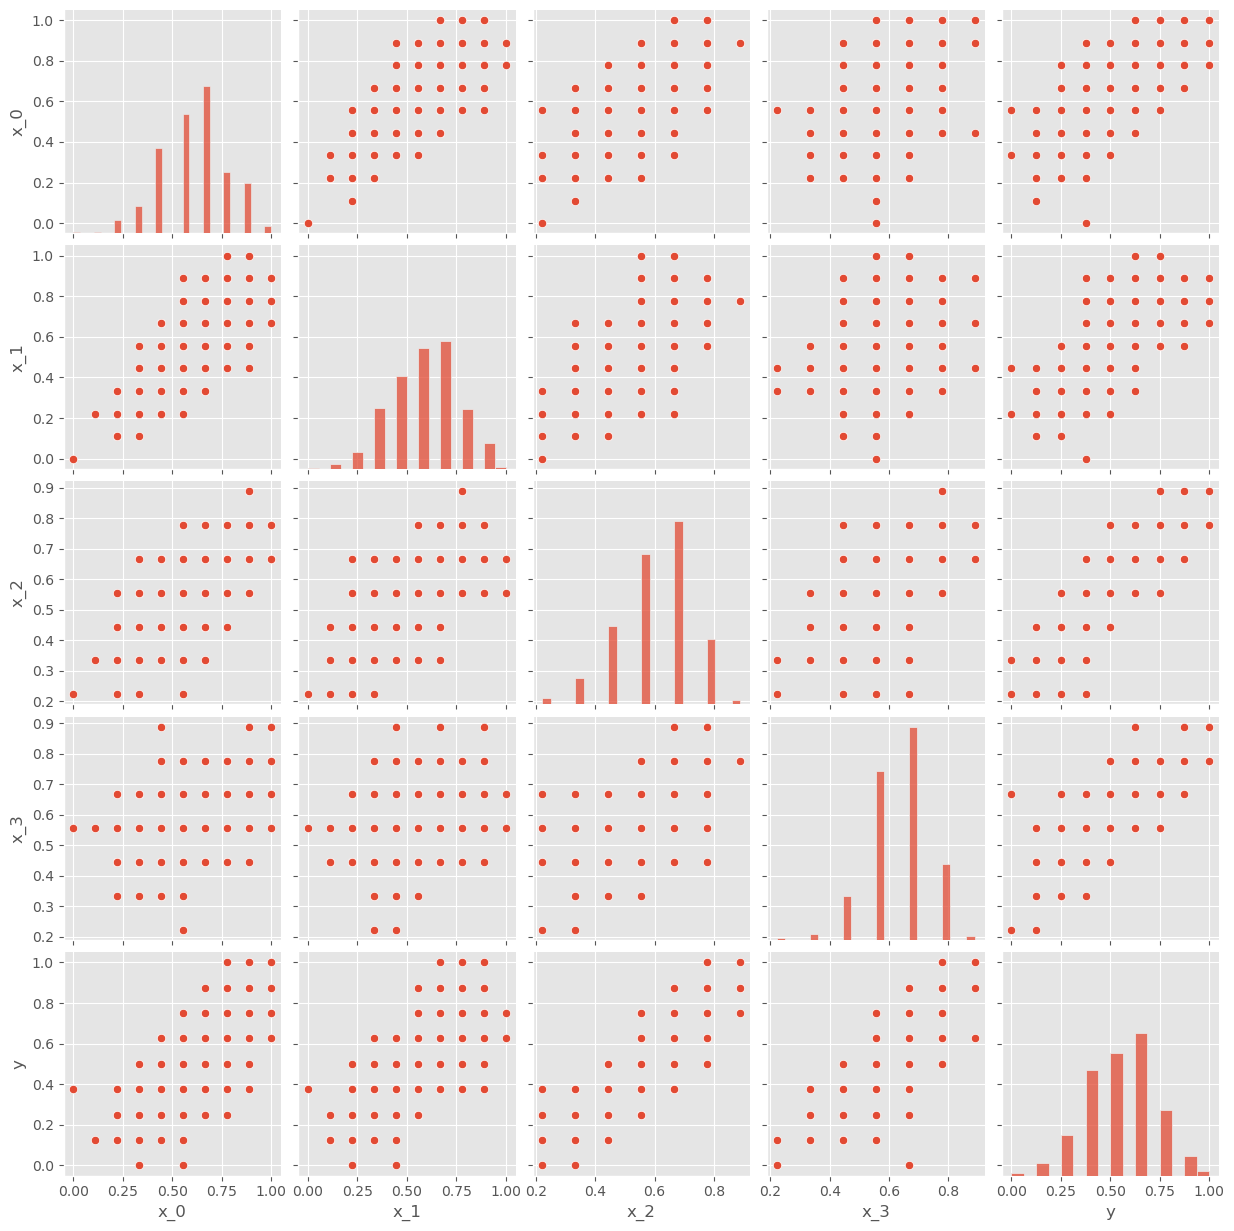

In [19]:
df_train = pd.DataFrame(X_tensor.numpy(),columns = ['x_{}'.format(i) for i in range(len(cols_selected))])
df_train['y']  = y_tensor.numpy()
sns.pairplot(df_train)
plt.show()

# MODELLING

#### GRID SEARCH

In [25]:
# Load grid_search results
grid_search_results = pd.read_csv('../logs/errors_log_ESL.csv')
grid_search_results.sort_values(by='MAE_Val', ascending=True, inplace=True)
grid_search_results.reset_index(drop=True, inplace=True)
# Reset index
grid_search_results.reset_index(drop=True, inplace=True)
grid_search_results.head(20)

,Layers,lr,weight_decay,RMSE_Train,RMSE_Val,RMSE_Test,MAE_Train,MAE_Val,MAE_Test,R2_Train,R2_Val,R2_Test,Global_Lipschitz,n_hidden_layers
0,"[4, 3, 1]",0.001,0.005,0.074782,0.052829,0.065826,0.056032,0.042289,0.048904,0.822315,0.892244,0.877608,0.465491,1
1,"[4, 2, 1]",0.001,0.005,0.075121,0.053082,0.065935,0.056180,0.042535,0.049052,0.820698,0.891209,0.877203,0.456162,1
2,"[4, 5, 5, 1]",0.001,0.005,0.074748,0.053154,0.064873,0.055928,0.042747,0.048307,0.822478,0.890916,0.881129,0.875596,2
3,"[4, 3, 3, 1]",0.001,0.005,0.075108,0.053449,0.065414,0.056160,0.042890,0.048731,0.820763,0.889700,0.879136,0.855790,2
4,"[4, 5, 1]",0.001,0.005,0.074805,0.053277,0.063910,0.055890,0.043014,0.047926,0.822205,0.890410,0.884631,0.428178,1
5,"[4, 5, 1]",0.010,0.005,0.074495,0.053289,0.063846,0.055730,0.043039,0.047792,0.823678,0.890362,0.884860,0.445789,1
6,"[4, 2, 1]",0.010,0.005,0.074912,0.053658,0.065375,0.056065,0.043136,0.048748,0.821697,0.888835,0.879282,0.434554,1
7,"[4, 3, 1]",0.010,0.005,0.074614,0.053642,0.064916,0.055880,0.043203,0.048342,0.823115,0.888902,0.880968,0.440981,1
8,"[4, 5, 5, 1]",0.010,0.005,0.074895,0.053887,0.065434,0.056065,0.043344,0.048817,0.821779,0.887887,0.879062,0.880892,2
9,"[4, 2, 2, 1]",0.001,0.005,0.076276,0.054320,0.066573,0.056873,0.043371,0.049905,0.815143,0.886078,0.874815,0.761644,2


#### NEURAL NETWORK

{'data_load': {'x_lim': [0, 1], 'y_lim': [0, 1]}, 'model_architecture': {'actfunc': ['tanh', 'tanh'], 'batch_size': None, 'layers': [4, 5, 5, 1]}, 'training': {'delta': 0.1, 'delta_external': 0.0, 'delta_synthetic': 0.0, 'epsilon_synthetic': 0.0, 'epsilon': 0.1, 'learning_rate': 0.001, 'monotone_relations': [1, 1, 1, 1], 'n_epochs': 5000, 'patience': 1000, 'plot_history': True, 'save_model': True, 'early_stopping': True, 'std_growth': 0.0, 'verbose': 1, 'weight_decay': 0.005, 'seed': 0, 'optimizer_type': 'Adam'}}
Using early stopping


[   0/5000]:   0%|          | 0/5001 [00:00<?, ?it/s, Train Loss=0.26, Train Loss Mod=2.5, Val Loss=0.245]

[3986/5000]:  80%|███████▉  | 3986/5001 [01:04<00:16, 62.09it/s, Train Loss=0.00563, Train Loss Mod=0.00563, Val Loss=0.0042] 


Early stopping at epoch 3986
3987


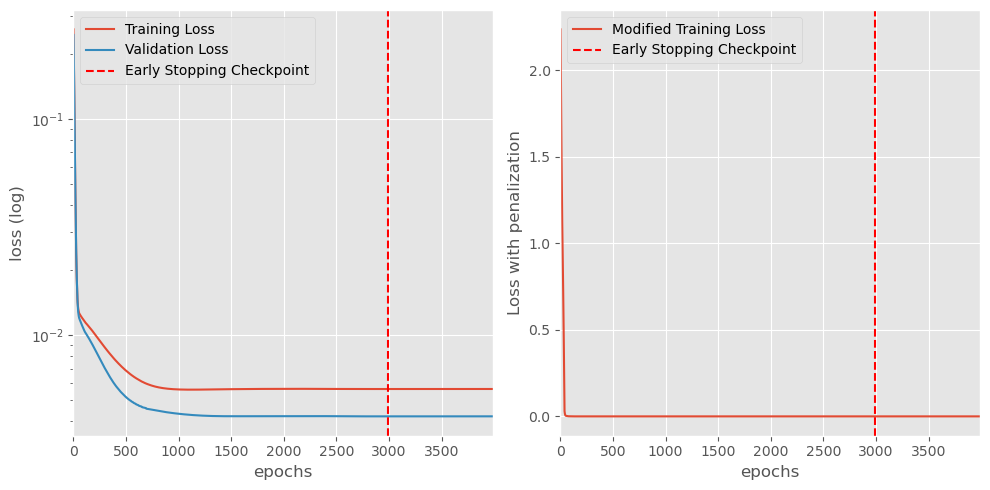

MSE Train: 0.0055934, MSE Val: 0.0028352, MSE Test: 0.0042028
RMSE Train: 0.0747889, RMSE Val: 0.0532466 , RMSE Test: 0.0648288
MAE Train: 0.0559411, MAE Val: 0.0428489, MAE Test: 0.0483006
R2 Train: 0.8222824, R2 Val: 0.8905347, R2 Test: 0.8812894


In [20]:
torch.manual_seed(0)
with open('../Scripts/config_rw.yaml') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
# Define the path to the folder
folder_path = './Models'
config['model_architecture']['layers'][0] = len(cols_selected)
config['training']['monotone_relations'] = [ 1 for i in range(len(cols_selected))]
print(config)

# Check if the folder exists
if not os.path.exists(folder_path):
    # If it doesn't exist, create it
    os.makedirs(folder_path)
NN_Monotonic = train(config)
model = NN_Monotonic._model
Utilities.print_errors(model,X_train_tensor,y_train_tensor,X_val_tensor,y_val_tensor, X_test_tensor,y_test_tensor)

In [ ]:
# MSE Train: 0.0055934, MSE Val: 0.0028352, MSE Test: 0.0042028
# RMSE Train: 0.0747889, RMSE Val: 0.0532466 , RMSE Test: 0.0648288
# MAE Train: 0.0559411, MAE Val: 0.0428489, MAE Test: 0.0483006
# R2 Train: 0.8222824, R2 Val: 0.8905347, R2 Test: 0.8812894

# VORONOI CHECK

In [21]:
### Compute Lipstchiz Constant
## Take one input and output random (it does not matter since the objective is to bound the Hessian for all inputs)
x = train_dataload.dataset.tensors[0][0].view(1,-1)
y = train_dataload.dataset.tensors[1][0].view(1,-1)

weights, biases = LipVor_functions.get_weights_and_biases(model)
# Just extract the weights and biases from the model independently of the activation functions
W, Z, O, D, D2, D_accum, Q, H, counter, mlpstr = calculate_second_partial_derivatives_mlp(weights,
                                                                                          biases, ['identity' for i in range(len(config['model_architecture']['actfunc']))],
                                                                                          x, y,sens_end_layer=len(config['model_architecture']['actfunc']))

## Calculate the Hessian for the first input
monotonic_vars = [0,1,2,3]
n_vars = 4
global_lipschitz_constant = LipVor_functions.hessian_bound(W=W,
                                                            actfunc=config['model_architecture']['actfunc'],
                                                            partial_monotonic_variable=monotonic_vars,
                                                            n_variables=n_vars)
print('Lipschitz Upper Bound: ', global_lipschitz_constant)

Lipschitz Upper Bound:  0.8796509614742688


In [22]:
# Lipschitz Upper Bound:  0.8796509614742688


In [72]:
LipVorCertification(model=model, actfunc=config['model_architecture']['actfunc'], weights=weights,biases= biases,
              monotone_relations=[1,1,1,1],variable_index=[0,1,2,3], global_lipschitz_constant=global_lipschitz_constant,
                  X_train_tensor=X_train_tensor, n_initial_points=10, max_iterations=1000, epsilon_derivative=0.1, epsilon_proyection=0.01, probability=0.0, seed=1)


          _____            _____                    _____                    _____                   _______                   _____          
         /\    \          /\    \                  /\    \                  /\    \                 /::\    \                 /\    \         
        /::\____\        /::\    \                /::\    \                /::\____\               /::::\    \               /::\    \        
       /:::/    /        \:::\    \              /::::\    \              /:::/    /              /::::::\    \             /::::\    \       
      /:::/    /          \:::\    \            /::::::\    \            /:::/    /              /::::::::\    \           /::::::\    \      
     /:::/    /            \:::\    \          /:::/\:::\    \          /:::/    /              /:::/--\:::\    \         /:::/\:::\    \     
    /:::/    /              \:::\    \        /:::/__\:::\    \        /:::/____/              /:::/    \:::\    \       /:::/__\:::\    \   

Processing iteration 578:  58%|█████▊    | 577/1000 [15:44<11:32,  1.64s/it, Percentage of vertex covered=99.83%, Percentage of Volume Verified=99.96%]

The space is filled: True after 578 iterations 
